In [1]:
from glob import glob
import pandas as pd

In [4]:
# Opción que deshabilita el limite de columnas y filas mostradas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

---
## Carga de data Yelp

In [2]:
# Path de los archivos no-procesados (formato parquet)
path_data = '../data/raw'

### `y-business.parquet`

In [4]:
df_business = pd.read_parquet(f'{path_data}/y-business.parquet')

### `y-checkin.parquet`

In [ ]:
df_checkin = pd.read_parquet(f'{path_data}/y-checkin.parquet')

### `y-tip.parquet`

In [ ]:
df_tip = pd.read_parquet(f'{path_data}/y-tip.parquet')

### `y-review.parquet`

In [ ]:
# Crear lista de archivos en /data/raw/y-review/
review_parquets = glob(f'{path_data}/y-review/*')
review_parquets

In [ ]:
# Crear dataframe donde se unen los datos extraidos de parquet
df_review = pd.DataFrame()
# Iterar por cada parquet dentro de /data/raw/y-review/
for p in review_parquets:
    # Leer parquet
    df = pd.read_parquet(p)
    # Unir a df_review
    df_review = pd.concat([df_review, df], ignore_index=True)

### `y-user.parquet`

In [ ]:
# Crear lista de archivos en /data/raw/y-user/
user_parquets = glob(f'{path_data}/y-user/*')
user_parquets

In [ ]:
# Crear dataframe donde se unen los datos extraidos de parquet
df_user = pd.DataFrame()
# Iterar por cada parquet dentro de /data/raw/y-user/
for p in user_parquets:
    # Leer parquet
    df = pd.read_parquet(p)
    # Unir a df_user
    df_user = pd.concat([df_user, df], ignore_index=True)

---
## Análisis Exploratorio

In [ ]:
# Revisar el dataset e imprimir las primeras filas
print(df_business.info())
df_business.head()

In [ ]:
# Completar los nulos con espacio para poder filtrar por categoría
df_business['categories'] = df_business['categories'].fillna('')

In [ ]:
# Dejar en el dataset solo la categoría 'Restaurants'
filtro_categoria = 'Restaurants'
df_business = df_business[df_business['categories'].str.contains(filtro_categoria, case=False)]
df_business.shape

In [ ]:
# Revisar la categorìa Restaurants
df_business.info()

Solo tenemos algunos nulos en "attributes" y "hours", que por el momento no se van a rellenar, hasta decidir si estas columnas serán utilizadas para los análisis.

In [ ]:
# Revisar las columnas numéricas
df_business.describe()

No se observan valores erróneos, como latirud y longitud con signo invertido, o calificaciones fuera del intérvalo 1 a 5.

In [ ]:
# Revisar el contenido de la columna "attributes"
df_business["attributes"].iloc[0]

Por el momento se va a mantener como está, hasta decidir si alguna de las "keys" puede ser de utilidad para algún análisis, y en ese caso se prodecerá a desanidar los datos.

In [ ]:
# Revisar las columnas
df_business.columns

#### Las siguientes columnas serán eliminadas:

addres: Se cuenta con los datos de latitud y longitud  
postal_code: Se cuenta con el nombre de las localidades  
is_open: Se entiende que se refiere al momento de la extracción de los datos. Se cuenta con los horarios de apertura y cierre


In [ ]:
# Eliminar las columnas antes mencionadas
df_business.drop("address", axis=1, inplace=True)
df_business.drop("postal_code", axis=1, inplace=True)
df_business.drop("is_open", axis=1, inplace=True)

In [ ]:
df_business.to_parquet(f'{path_data}/etl-business.parquet')

-------------------

In [ ]:
# Revisar el dataset
print(df_checkin.info())
df_checkin.head()

#### En principio no vamos a realizar análisis que incluyan la fecha y hora de ingreso de los usuarios al local. Este dataset no se va a utilizar, por lo que no se va a desanidar la columna de registros (date), ni se va a realizar ningún otro proceso sobre el mismo. Se observa de todos modos que el dataset no contiene valores nulos.

-------------------

In [ ]:
# Revisar el dataset
print(df_tip.info())
df_tip.head()


In [ ]:
df_tip.describe()

Los datos no contienen nulos y están en el formato correcto.

In [ ]:
# Sacar los id de los locales filtrados por categoría Restaurante
locales_restaurants = df_business["business_id"]

In [ ]:
# Filtrar los tip a Restaurante
df_tip = df_tip[df_tip["business_id"].isin(locales_restaurants)]
df_tip.shape


In [ ]:
df_tip.to_parquet(f'{path_data}/etl-tip.parquet')

---

In [ ]:
df_user.info()

## Mapa

In [5]:
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [6]:
df_business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

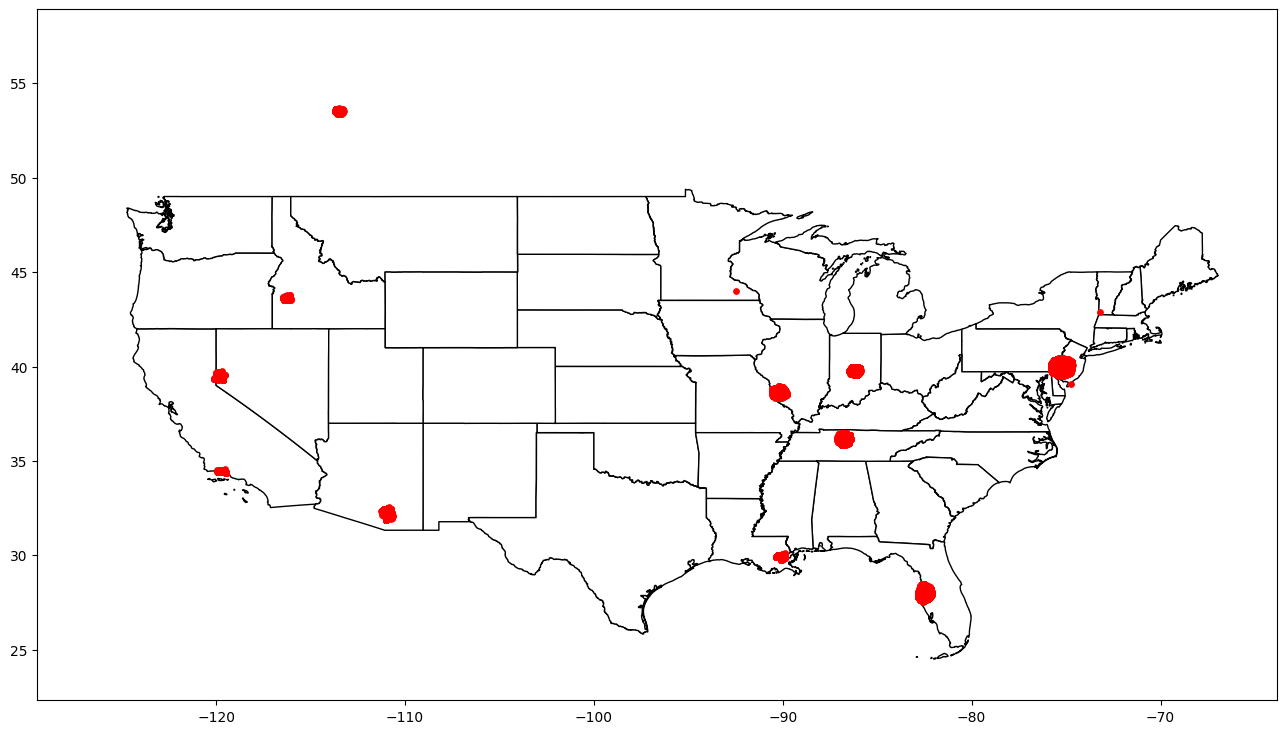

In [11]:
# Mapeamos las coordinadas de 'pos_x' y 'pos_y'
# Descartamos los nulos
df = df_business.dropna(axis=0, subset=['longitude', 'latitude'])

# Crear un GeoDataFrame con la data de coordinadas
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

# Cargar archivo shapefile
mapa = gpd.read_file('../assets/map_state_5m.shp')

# Calculamos los limites del mapa
minx, miny, maxx, maxy = gdf.total_bounds

# Creamos los plots del mapa
fig, ax = plt.subplots(figsize=(16, 14))
mapa.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=15)

# Calculamos el margen del grafico
margin_ratio = 0.2
marginx = (maxx - minx) * margin_ratio
marginy = (maxy - miny) * margin_ratio
# Aplicamos los margenes en relacion a los plots en los extremos
ax.set_xlim(minx - marginx, maxx + marginx)
ax.set_ylim(miny - marginy, maxy + marginy)

plt.show()